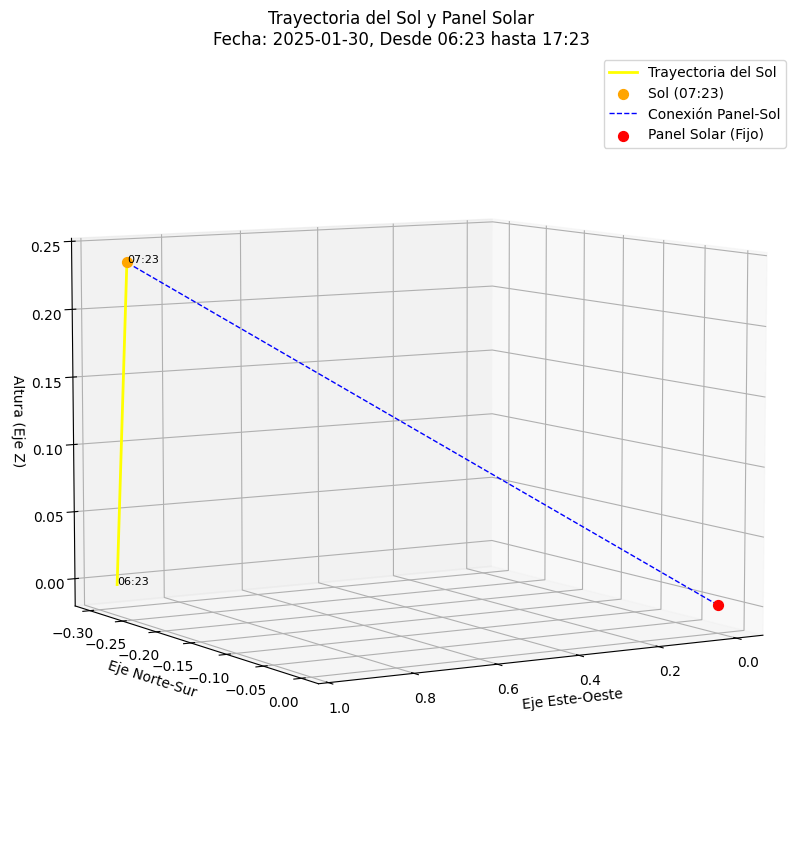

In [8]:
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import numpy as np
import tkinter as tk
from datetime import datetime, timedelta
from pytz import timezone
from pysolar.solar import get_altitude, get_azimuth
from astral import LocationInfo
from astral.sun import sun

def getSolarPosition(latitude: float, longitude: float, date: datetime):
    """Calcula el azimut y la elevación para una posición geográfica y fecha."""
    az = get_azimuth(latitude, longitude, date)
    el = get_altitude(latitude, longitude, date)
    return az, el

def get_sunrise_sunset(latitude, longitude, date):
    """Obtiene la hora real de salida y puesta del sol para la ubicación y fecha ingresadas."""
    location = LocationInfo("Guayaquil", "Ecuador", "America/Guayaquil", latitude, longitude)
    s = sun(location.observer, date=date, tzinfo=timezone("America/Guayaquil"))
    return s['sunrise'].astimezone(timezone("America/Guayaquil")), s['sunset'].astimezone(timezone("America/Guayaquil"))

def interactive_plot():
    """Crea una interfaz para ingresar la fecha, duración y ubicación."""
    root = tk.Tk()
    root.title("Configuración de la Simulación Solar")
    
    tk.Label(root, text="Latitud:").grid(row=0, column=0)
    lat_entry = tk.Entry(root)
    lat_entry.grid(row=0, column=1)
    lat_entry.insert(0, "-0.2105367")
    
    tk.Label(root, text="Longitud:").grid(row=1, column=0)
    lon_entry = tk.Entry(root)
    lon_entry.grid(row=1, column=1)
    lon_entry.insert(0, "-78.491614")
    
    tk.Label(root, text="Fecha (YYYY-MM-DD):").grid(row=2, column=0)
    date_entry = tk.Entry(root)
    date_entry.grid(row=2, column=1)
    date_entry.insert(0, datetime.now().strftime("%Y-%m-%d"))
    
    tk.Label(root, text="Duración (horas):").grid(row=3, column=0)
    duration_entry = tk.Entry(root)
    duration_entry.grid(row=3, column=1)
    duration_entry.insert(0, "12")
    
    sunrise_label = tk.Label(root, text="")
    sunrise_label.grid(row=5, column=0, columnspan=2)
    
    def update_sun_times():
        latitude = float(lat_entry.get())
        longitude = float(lon_entry.get())
        date = datetime.strptime(date_entry.get(), "%Y-%m-%d").date()
        sunrise, sunset = get_sunrise_sunset(latitude, longitude, date)
        sunrise_label.config(text=f"Salida del Sol: {sunrise.strftime('%H:%M')}  |  Puesta del Sol: {sunset.strftime('%H:%M')}")
    
    update_sun_times_button = tk.Button(root, text="Obtener Horas del Sol", command=update_sun_times)
    update_sun_times_button.grid(row=4, column=0, columnspan=2)
    
    def start_simulation():
        latitude = float(lat_entry.get())
        longitude = float(lon_entry.get())
        date = datetime.strptime(date_entry.get(), "%Y-%m-%d").date()
        duration = int(duration_entry.get())
        sunrise, sunset = get_sunrise_sunset(latitude, longitude, date)
        max_end_time = sunrise + timedelta(hours=duration)
        end_time = min(max_end_time, sunset)  # Se detiene en el tiempo de duración o puesta de sol
        root.destroy()
        plotSunAndPanelTrajectoryInWindow(sunrise, end_time, latitude, longitude)
    
    start_button = tk.Button(root, text="Iniciar Simulación", command=start_simulation)
    start_button.grid(row=6, column=0, columnspan=2)
    root.mainloop()

def plotSunAndPanelTrajectoryInWindow(start_time, end_time, latitude, longitude):
    """Dibuja la trayectoria del sol desde la salida hasta la puesta del sol."""
    times = []
    current_time = start_time
    while current_time <= end_time:
        times.append(current_time)
        current_time += timedelta(hours=1)  # Se actualiza cada hora
    
    azimuths, elevations = zip(*[getSolarPosition(latitude, longitude, time) for time in times])
    sun_x, sun_y, sun_z = spherical_to_cartesian(azimuths, elevations)
    panel_x, panel_y, panel_z = [0], [0], [0]
    
    root = tk.Tk()
    root.title("Trayectoria del Sol y Panel Solar")
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
    
    def update_plot(i=0):
        if i < len(sun_x):
            ax.clear()
            ax.plot(sun_x[:i+1], sun_y[:i+1], sun_z[:i+1], label='Trayectoria del Sol', color='yellow', linewidth=2)
            ax.scatter(sun_x[i], sun_y[i], sun_z[i], color='orange', label=f'Sol ({times[i].strftime("%H:%M")})', s=50)
            ax.plot([panel_x[0], sun_x[i]], [panel_y[0], sun_y[i]], [panel_z[0], sun_z[i]], color='blue', linestyle='dashed', linewidth=1, label='Conexión Panel-Sol')
            ax.scatter(panel_x, panel_y, panel_z, color='red', label='Panel Solar (Fijo)', s=50)
            
            for j in range(i + 1):
                ax.text(sun_x[j], sun_y[j], sun_z[j], times[j].strftime('%H:%M'), fontsize=8, color='black')
            
            ax.set_xlabel('Eje Este-Oeste')
            ax.set_ylabel('Eje Norte-Sur')
            ax.set_zlabel('Altura (Eje Z)')
            ax.set_title(f'Trayectoria del Sol y Panel Solar\nFecha: {start_time.strftime("%Y-%m-%d")}, Desde {start_time.strftime("%H:%M")} hasta {end_time.strftime("%H:%M")}')
            ax.legend()
            canvas.draw()
            root.after(500, update_plot, i + 1)  
        else:
            root.after(1000, update_plot, 0)  
    
    update_plot()
    root.mainloop()

def spherical_to_cartesian(azimuths, elevations):
    """Convierte azimut y elevación a coordenadas 3D esféricas."""
    azimuths_rad = np.radians(azimuths)
    elevations_rad = np.radians(elevations)
    sun_x = np.cos(elevations_rad) * np.sin(azimuths_rad)
    sun_y = np.cos(elevations_rad) * np.cos(azimuths_rad)
    sun_z = np.sin(elevations_rad)
    return sun_x, sun_y, sun_z

if __name__ == "__main__":
    interactive_plot()


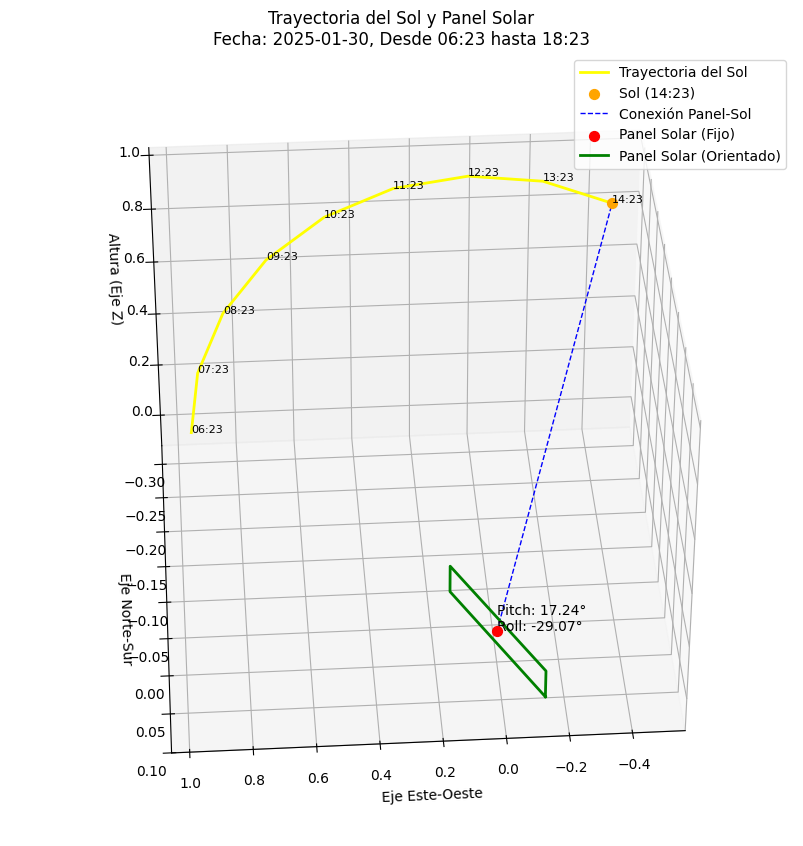

In [12]:
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import numpy as np
import tkinter as tk
from datetime import datetime, timedelta
from pytz import timezone
from pysolar.solar import get_altitude, get_azimuth
from astral import LocationInfo
from astral.sun import sun
import math

def getSolarPosition(latitude: float, longitude: float, date: datetime):
    """Calcula el azimut y la elevación para una posición geográfica y fecha."""
    az = get_azimuth(latitude, longitude, date)
    el = get_altitude(latitude, longitude, date)
    return az, el

def get_sunrise_sunset(latitude, longitude, date):
    """Obtiene la hora real de salida y puesta del sol para la ubicación y fecha ingresadas."""
    location = LocationInfo("Guayaquil", "Ecuador", "America/Guayaquil", latitude, longitude)
    s = sun(location.observer, date=date, tzinfo=timezone("America/Guayaquil"))
    return s['sunrise'].astimezone(timezone("America/Guayaquil")), s['sunset'].astimezone(timezone("America/Guayaquil"))

def calculate_pitch_roll(azimuth, elevation):
    """Calcula los ángulos de pitch y roll para mantener el panel perpendicular al sol."""
    theta = math.radians(elevation)
    alpha = math.radians(azimuth)

    pitch = math.degrees(math.asin(-math.cos(theta) * math.cos(alpha)))
    roll = math.degrees(math.atan2(math.cos(theta) * math.sin(alpha), math.sin(theta)))

    return pitch, roll

def interactive_plot():
    """Crea una interfaz para ingresar la fecha, duración y ubicación."""
    root = tk.Tk()
    root.title("Configuración de la Simulación Solar")

    tk.Label(root, text="Latitud:").grid(row=0, column=0)
    lat_entry = tk.Entry(root)
    lat_entry.grid(row=0, column=1)
    lat_entry.insert(0, "-0.2105367")

    tk.Label(root, text="Longitud:").grid(row=1, column=0)
    lon_entry = tk.Entry(root)
    lon_entry.grid(row=1, column=1)
    lon_entry.insert(0, "-78.491614")

    tk.Label(root, text="Fecha (YYYY-MM-DD):").grid(row=2, column=0)
    date_entry = tk.Entry(root)
    date_entry.grid(row=2, column=1)
    date_entry.insert(0, datetime.now().strftime("%Y-%m-%d"))

    tk.Label(root, text="Duración (horas):").grid(row=3, column=0)
    duration_entry = tk.Entry(root)
    duration_entry.grid(row=3, column=1)
    duration_entry.insert(0, "12")

    sunrise_label = tk.Label(root, text="")
    sunrise_label.grid(row=5, column=0, columnspan=2)

    def update_sun_times():
        latitude = float(lat_entry.get())
        longitude = float(lon_entry.get())
        date = datetime.strptime(date_entry.get(), "%Y-%m-%d").date()
        sunrise, sunset = get_sunrise_sunset(latitude, longitude, date)
        sunrise_label.config(text=f"Salida del Sol: {sunrise.strftime('%H:%M')}  |  Puesta del Sol: {sunset.strftime('%H:%M')}")

    update_sun_times_button = tk.Button(root, text="Obtener Horas del Sol", command=update_sun_times)
    update_sun_times_button.grid(row=4, column=0, columnspan=2)

    def start_simulation():
        latitude = float(lat_entry.get())
        longitude = float(lon_entry.get())
        date = datetime.strptime(date_entry.get(), "%Y-%m-%d").date()
        duration = int(duration_entry.get())
        sunrise, sunset = get_sunrise_sunset(latitude, longitude, date)
        max_end_time = sunrise + timedelta(hours=duration)
        end_time = min(max_end_time, sunset)  # Se detiene en el tiempo de duración o puesta de sol
        root.destroy()
        plotSunAndPanelTrajectoryInWindow(sunrise, end_time, latitude, longitude)

    start_button = tk.Button(root, text="Iniciar Simulación", command=start_simulation)
    start_button.grid(row=6, column=0, columnspan=2)
    root.mainloop()

def plotSunAndPanelTrajectoryInWindow(start_time, end_time, latitude, longitude):
    """Dibuja la trayectoria del sol desde la salida hasta la puesta del sol."""
    times = []
    current_time = start_time
    while current_time <= end_time:
        times.append(current_time)
        current_time += timedelta(hours=1)  # Se actualiza cada hora

    azimuths, elevations = zip(*[getSolarPosition(latitude, longitude, time) for time in times])
    sun_x, sun_y, sun_z = spherical_to_cartesian(azimuths, elevations)
    panel_x, panel_y, panel_z = [0], [0], [0]

    root = tk.Tk()
    root.title("Trayectoria del Sol y Panel Solar")
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    def update_plot(i=0):
        if i < len(sun_x):
            ax.clear()
            ax.plot(sun_x[:i+1], sun_y[:i+1], sun_z[:i+1], label='Trayectoria del Sol', color='yellow', linewidth=2)
            ax.scatter(sun_x[i], sun_y[i], sun_z[i], color='orange', label=f'Sol ({times[i].strftime("%H:%M")})', s=50)
            ax.plot([panel_x[0], sun_x[i]], [panel_y[0], sun_y[i]], [panel_z[0], sun_z[i]], color='blue', linestyle='dashed', linewidth=1, label='Conexión Panel-Sol')
            ax.scatter(panel_x, panel_y, panel_z, color='red', label='Panel Solar (Fijo)', s=50)

            # Representación gráfica del panel solar como un rectángulo con inclinación
            pitch, roll = calculate_pitch_roll(azimuths[i], elevations[i])
            panel_width, panel_height = 0.3, 0.1
            rect_x = [-panel_width/2, panel_width/2, panel_width/2, -panel_width/2, -panel_width/2]
            rect_y = [0, 0, 0, 0, 0]
            rect_z = [-panel_height/2, -panel_height/2, panel_height/2, panel_height/2, -panel_height/2]

            rotation_matrix = np.array([
                [np.cos(np.radians(roll)), -np.sin(np.radians(roll)), 0],
                [np.sin(np.radians(roll)), np.cos(np.radians(roll)), 0],
                [0, 0, 1]
            ])

            rotated_rect = np.dot(rotation_matrix, np.array([rect_x, rect_y, rect_z]))
            ax.plot(rotated_rect[0], rotated_rect[1], rotated_rect[2], color='green', label='Panel Solar (Orientado)', linewidth=2)

            ax.text(0, 0, 0, f"Pitch: {pitch:.2f}°\nRoll: {roll:.2f}°", fontsize=10, color='black')

            for j in range(i + 1):
                ax.text(sun_x[j], sun_y[j], sun_z[j], times[j].strftime('%H:%M'), fontsize=8, color='black')

            ax.set_xlabel('Eje Este-Oeste')
            ax.set_ylabel('Eje Norte-Sur')
            ax.set_zlabel('Altura (Eje Z)')
            ax.set_title(f'Trayectoria del Sol y Panel Solar\nFecha: {start_time.strftime("%Y-%m-%d")}, Desde {start_time.strftime("%H:%M")} hasta {end_time.strftime("%H:%M")}')
            ax.legend()
            canvas.draw()
            root.after(500, update_plot, i + 1)  
        else:
            root.after(1000, update_plot, 0)  

    update_plot()
    root.mainloop()

def spherical_to_cartesian(azimuths, elevations):
    """Convierte azimut y elevación a coordenadas 3D esféricas."""
    azimuths_rad = np.radians(azimuths)
    elevations_rad = np.radians(elevations)
    sun_x = np.cos(elevations_rad) * np.sin(azimuths_rad)
    sun_y = np.cos(elevations_rad) * np.cos(azimuths_rad)
    sun_z = np.sin(elevations_rad)
    return sun_x, sun_y, sun_z

if __name__ == "__main__":
    interactive_plot()


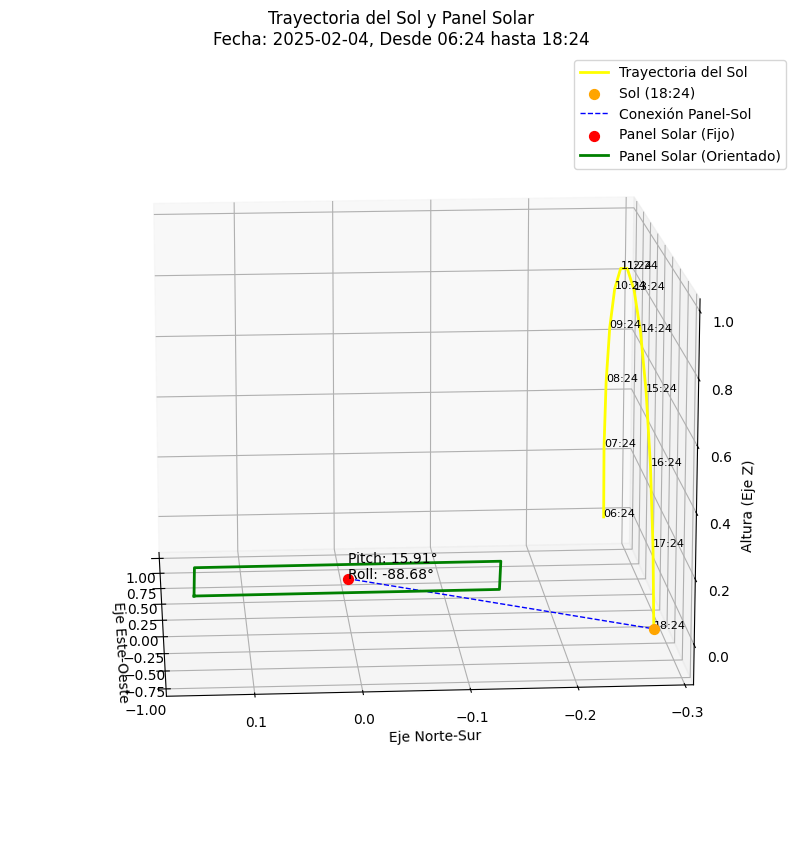

In [1]:
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import numpy as np
import tkinter as tk
from datetime import datetime, timedelta
from pytz import timezone
from pysolar.solar import get_altitude, get_azimuth
from astral import LocationInfo
from astral.sun import sun
import math

def getSolarPosition(latitude: float, longitude: float, date: datetime):
    """Calcula el azimut y la elevación para una posición geográfica y fecha."""
    az = get_azimuth(latitude, longitude, date)
    el = get_altitude(latitude, longitude, date)
    return az, el

def get_sunrise_sunset(latitude, longitude, date):
    """Obtiene la hora real de salida y puesta del sol para la ubicación y fecha ingresadas."""
    location = LocationInfo("Guayaquil", "Ecuador", "America/Guayaquil", latitude, longitude)
    s = sun(location.observer, date=date, tzinfo=timezone("America/Guayaquil"))
    return s['sunrise'].astimezone(timezone("America/Guayaquil")), s['sunset'].astimezone(timezone("America/Guayaquil"))

def calculate_pitch_roll(azimuth, elevation):
    """Calcula los ángulos de pitch y roll para mantener el panel perpendicular al sol."""
    theta = math.radians(elevation)
    alpha = math.radians(azimuth)

    pitch = math.degrees(math.asin(-math.cos(theta) * math.cos(alpha)))
    roll = math.degrees(math.atan2(math.cos(theta) * math.sin(alpha), math.sin(theta)))

    return pitch, roll

def interactive_plot():
    """Crea una interfaz para ingresar la fecha, duración y ubicación."""
    root = tk.Tk()
    root.title("Configuración de la Simulación Solar")

    tk.Label(root, text="Latitud:").grid(row=0, column=0)
    lat_entry = tk.Entry(root)
    lat_entry.grid(row=0, column=1)
    lat_entry.insert(0, "-0.2105367")

    tk.Label(root, text="Longitud:").grid(row=1, column=0)
    lon_entry = tk.Entry(root)
    lon_entry.grid(row=1, column=1)
    lon_entry.insert(0, "-78.491614")

    tk.Label(root, text="Fecha (YYYY-MM-DD):").grid(row=2, column=0)
    date_entry = tk.Entry(root)
    date_entry.grid(row=2, column=1)
    date_entry.insert(0, datetime.now().strftime("%Y-%m-%d"))

    tk.Label(root, text="Duración (horas):").grid(row=3, column=0)
    duration_entry = tk.Entry(root)
    duration_entry.grid(row=3, column=1)
    duration_entry.insert(0, "12")

    sunrise_label = tk.Label(root, text="")
    sunrise_label.grid(row=5, column=0, columnspan=2)

    def update_sun_times():
        latitude = float(lat_entry.get())
        longitude = float(lon_entry.get())
        date = datetime.strptime(date_entry.get(), "%Y-%m-%d").date()
        sunrise, sunset = get_sunrise_sunset(latitude, longitude, date)
        sunrise_label.config(text=f"Salida del Sol: {sunrise.strftime('%H:%M')}  |  Puesta del Sol: {sunset.strftime('%H:%M')}")

    update_sun_times_button = tk.Button(root, text="Obtener Horas del Sol", command=update_sun_times)
    update_sun_times_button.grid(row=4, column=0, columnspan=2)

    def start_simulation():
        latitude = float(lat_entry.get())
        longitude = float(lon_entry.get())
        date = datetime.strptime(date_entry.get(), "%Y-%m-%d").date()
        duration = int(duration_entry.get())
        sunrise, sunset = get_sunrise_sunset(latitude, longitude, date)
        max_end_time = sunrise + timedelta(hours=duration)
        end_time = min(max_end_time, sunset)  # Se detiene en el tiempo de duración o puesta de sol
        root.destroy()
        plotSunAndPanelTrajectoryInWindow(sunrise, end_time, latitude, longitude)

    start_button = tk.Button(root, text="Iniciar Simulación", command=start_simulation)
    start_button.grid(row=6, column=0, columnspan=2)
    root.mainloop()

def plotSunAndPanelTrajectoryInWindow(start_time, end_time, latitude, longitude):
    """Dibuja la trayectoria del sol desde la salida hasta la puesta del sol."""
    times = []
    current_time = start_time
    while current_time <= end_time:
        times.append(current_time)
        current_time += timedelta(hours=1)  # Se actualiza cada hora

    azimuths, elevations = zip(*[getSolarPosition(latitude, longitude, time) for time in times])
    sun_x, sun_y, sun_z = spherical_to_cartesian(azimuths, elevations)
    panel_x, panel_y, panel_z = [0], [0], [0]

    root = tk.Tk()
    root.title("Trayectoria del Sol y Panel Solar")
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    def update_plot(i=0):
        if i < len(sun_x):
            ax.clear()
            ax.plot(sun_x[:i+1], sun_y[:i+1], sun_z[:i+1], label='Trayectoria del Sol', color='yellow', linewidth=2)
            ax.scatter(sun_x[i], sun_y[i], sun_z[i], color='orange', label=f'Sol ({times[i].strftime("%H:%M")})', s=50)
            ax.plot([panel_x[0], sun_x[i]], [panel_y[0], sun_y[i]], [panel_z[0], sun_z[i]], color='blue', linestyle='dashed', linewidth=1, label='Conexión Panel-Sol')
            ax.scatter(panel_x, panel_y, panel_z, color='red', label='Panel Solar (Fijo)', s=50)

            # Representación gráfica del panel solar como un rectángulo con inclinación
            pitch, roll = calculate_pitch_roll(azimuths[i], elevations[i])
            panel_width, panel_height = 0.3, 0.1
            rect_x = [-panel_width/2, panel_width/2, panel_width/2, -panel_width/2, -panel_width/2]
            rect_y = [0, 0, 0, 0, 0]
            rect_z = [-panel_height/2, -panel_height/2, panel_height/2, panel_height/2, -panel_height/2]

            # Rotar el panel en función del pitch y roll
            rotation_matrix_roll = np.array([
                [np.cos(np.radians(roll)), -np.sin(np.radians(roll)), 0],
                [np.sin(np.radians(roll)), np.cos(np.radians(roll)), 0],
                [0, 0, 1]
            ])
            rotation_matrix_pitch = np.array([
                [1, 0, 0],
                [0, np.cos(np.radians(pitch)), -np.sin(np.radians(pitch))],
                [0, np.sin(np.radians(pitch)), np.cos(np.radians(pitch))]
            ])
            rotated_rect = np.dot(rotation_matrix_roll, np.dot(rotation_matrix_pitch, np.array([rect_x, rect_y, rect_z])))

            ax.plot(rotated_rect[0], rotated_rect[1], rotated_rect[2], color='green', label='Panel Solar (Orientado)', linewidth=2)

            ax.text(0, 0, 0, f"Pitch: {pitch:.2f}°\nRoll: {roll:.2f}°", fontsize=10, color='black')

            for j in range(i + 1):
                ax.text(sun_x[j], sun_y[j], sun_z[j], times[j].strftime('%H:%M'), fontsize=8, color='black')

            ax.set_xlabel('Eje Este-Oeste')
            ax.set_ylabel('Eje Norte-Sur')
            ax.set_zlabel('Altura (Eje Z)')
            ax.set_title(f'Trayectoria del Sol y Panel Solar\nFecha: {start_time.strftime("%Y-%m-%d")}, Desde {start_time.strftime("%H:%M")} hasta {end_time.strftime("%H:%M")}')
            ax.legend()
            canvas.draw()
            root.after(500, update_plot, i + 1)  
        else:
            root.after(1000, update_plot, 0)  

    update_plot()
    root.mainloop()

def spherical_to_cartesian(azimuths, elevations):
    """Convierte azimut y elevación a coordenadas 3D esféricas."""
    azimuths_rad = np.radians(azimuths)
    elevations_rad = np.radians(elevations)
    sun_x = np.cos(elevations_rad) * np.sin(azimuths_rad)
    sun_y = np.cos(elevations_rad) * np.cos(azimuths_rad)
    sun_z = np.sin(elevations_rad)
    return sun_x, sun_y, sun_z

if __name__ == "__main__":
    interactive_plot()


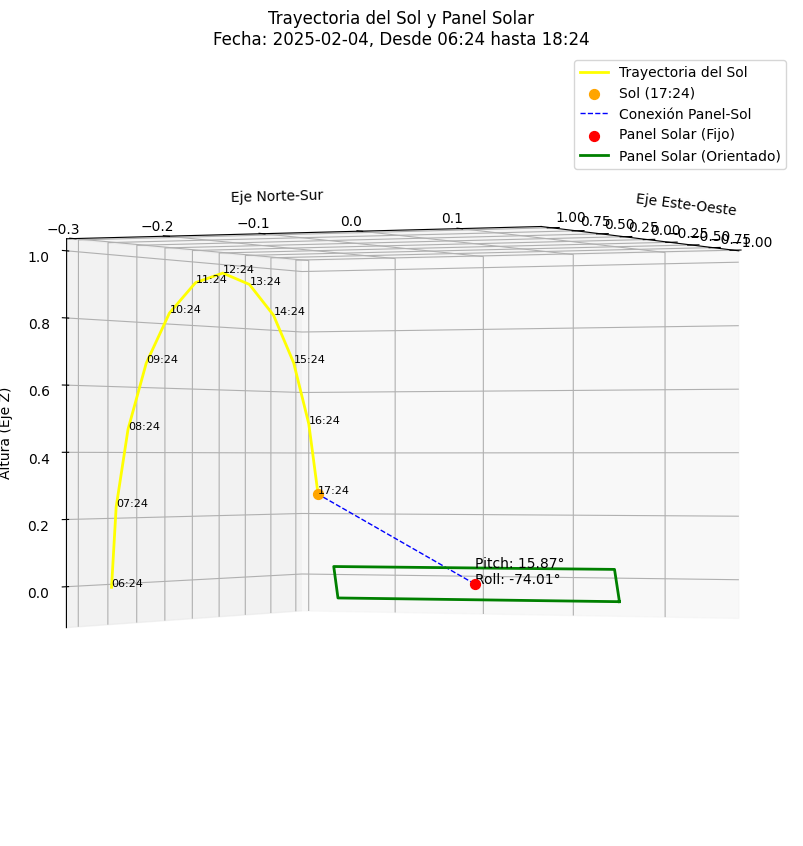

In [2]:
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import numpy as np
import tkinter as tk
from datetime import datetime, timedelta
from pytz import timezone
from pysolar.solar import get_altitude, get_azimuth
from astral import LocationInfo
from astral.sun import sun
import math

def getSolarPosition(latitude: float, longitude: float, date: datetime):
    """Calcula el azimut y la elevación para una posición geográfica y fecha."""
    az = get_azimuth(latitude, longitude, date)
    el = get_altitude(latitude, longitude, date)
    return az, el

def get_sunrise_sunset(latitude, longitude, date):
    """Obtiene la hora real de salida y puesta del sol para la ubicación y fecha ingresadas."""
    location = LocationInfo("Guayaquil", "Ecuador", "America/Guayaquil", latitude, longitude)
    s = sun(location.observer, date=date, tzinfo=timezone("America/Guayaquil"))
    return s['sunrise'].astimezone(timezone("America/Guayaquil")), s['sunset'].astimezone(timezone("America/Guayaquil"))

def calculate_pitch_roll(azimuth, elevation):
    """Calcula los ángulos de pitch y roll para mantener el panel perpendicular al sol."""
    theta = math.radians(elevation)
    alpha = math.radians(azimuth)

    pitch = math.degrees(math.asin(-math.cos(theta) * math.cos(alpha)))
    roll = math.degrees(math.atan2(math.cos(theta) * math.sin(alpha), math.sin(theta)))

    return pitch, roll

def interactive_plot():
    """Crea una interfaz para ingresar la fecha, duración y ubicación."""
    root = tk.Tk()
    root.title("Configuración de la Simulación Solar")

    tk.Label(root, text="Latitud:").grid(row=0, column=0)
    lat_entry = tk.Entry(root)
    lat_entry.grid(row=0, column=1)
    lat_entry.insert(0, "-0.2105367")

    tk.Label(root, text="Longitud:").grid(row=1, column=0)
    lon_entry = tk.Entry(root)
    lon_entry.grid(row=1, column=1)
    lon_entry.insert(0, "-78.491614")

    tk.Label(root, text="Fecha (YYYY-MM-DD):").grid(row=2, column=0)
    date_entry = tk.Entry(root)
    date_entry.grid(row=2, column=1)
    date_entry.insert(0, datetime.now().strftime("%Y-%m-%d"))

    tk.Label(root, text="Duración (horas):").grid(row=3, column=0)
    duration_entry = tk.Entry(root)
    duration_entry.grid(row=3, column=1)
    duration_entry.insert(0, "12")

    sunrise_label = tk.Label(root, text="")
    sunrise_label.grid(row=5, column=0, columnspan=2)

    def update_sun_times():
        latitude = float(lat_entry.get())
        longitude = float(lon_entry.get())
        date = datetime.strptime(date_entry.get(), "%Y-%m-%d").date()
        sunrise, sunset = get_sunrise_sunset(latitude, longitude, date)
        sunrise_label.config(text=f"Salida del Sol: {sunrise.strftime('%H:%M')}  |  Puesta del Sol: {sunset.strftime('%H:%M')}")

    update_sun_times_button = tk.Button(root, text="Obtener Horas del Sol", command=update_sun_times)
    update_sun_times_button.grid(row=4, column=0, columnspan=2)

    def start_simulation():
        latitude = float(lat_entry.get())
        longitude = float(lon_entry.get())
        date = datetime.strptime(date_entry.get(), "%Y-%m-%d").date()
        duration = int(duration_entry.get())
        sunrise, sunset = get_sunrise_sunset(latitude, longitude, date)
        max_end_time = sunrise + timedelta(hours=duration)
        end_time = min(max_end_time, sunset)  # Se detiene en el tiempo de duración o puesta de sol
        root.destroy()
        plotSunAndPanelTrajectoryInWindow(sunrise, end_time, latitude, longitude)

    start_button = tk.Button(root, text="Iniciar Simulación", command=start_simulation)
    start_button.grid(row=6, column=0, columnspan=2)
    root.mainloop()

def plotSunAndPanelTrajectoryInWindow(start_time, end_time, latitude, longitude):
    """Dibuja la trayectoria del sol desde la salida hasta la puesta del sol."""
    times = []
    current_time = start_time
    while current_time <= end_time:
        times.append(current_time)
        current_time += timedelta(hours=1)  # Se actualiza cada hora

    azimuths, elevations = zip(*[getSolarPosition(latitude, longitude, time) for time in times])
    sun_x, sun_y, sun_z = spherical_to_cartesian(azimuths, elevations)
    panel_x, panel_y, panel_z = [0], [0], [0]

    root = tk.Tk()
    root.title("Trayectoria del Sol y Panel Solar")
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    def update_plot(i=0):
        if i < len(sun_x):
            ax.clear()
            ax.plot(sun_x[:i+1], sun_y[:i+1], sun_z[:i+1], label='Trayectoria del Sol', color='yellow', linewidth=2)
            ax.scatter(sun_x[i], sun_y[i], sun_z[i], color='orange', label=f'Sol ({times[i].strftime("%H:%M")})', s=50)
            ax.plot([panel_x[0], sun_x[i]], [panel_y[0], sun_y[i]], [panel_z[0], sun_z[i]], color='blue', linestyle='dashed', linewidth=1, label='Conexión Panel-Sol')
            ax.scatter(panel_x, panel_y, panel_z, color='red', label='Panel Solar (Fijo)', s=50)

            # Representación gráfica del panel solar como un rectángulo con inclinación
            pitch, roll = calculate_pitch_roll(azimuths[i], elevations[i])
            panel_width, panel_height = 0.3, 0.1
            rect_x = [-panel_width/2, panel_width/2, panel_width/2, -panel_width/2, -panel_width/2]
            rect_y = [0, 0, 0, 0, 0]
            rect_z = [-panel_height/2, -panel_height/2, panel_height/2, panel_height/2, -panel_height/2]

            # Rotar el panel en función del pitch y roll
            rotation_matrix_roll = np.array([
                [np.cos(np.radians(roll)), -np.sin(np.radians(roll)), 0],
                [np.sin(np.radians(roll)), np.cos(np.radians(roll)), 0],
                [0, 0, 1]
            ])
            rotation_matrix_pitch = np.array([
                [1, 0, 0],
                [0, np.cos(np.radians(pitch)), -np.sin(np.radians(pitch))],
                [0, np.sin(np.radians(pitch)), np.cos(np.radians(pitch))]
            ])
            rotated_rect = np.dot(rotation_matrix_roll, np.dot(rotation_matrix_pitch, np.array([rect_x, rect_y, rect_z])))

            ax.plot(rotated_rect[0], rotated_rect[1], rotated_rect[2], color='green', label='Panel Solar (Orientado)', linewidth=2)

            ax.text(0, 0, 0, f"Pitch: {pitch:.2f}°\nRoll: {roll:.2f}°", fontsize=10, color='black')

            for j in range(i + 1):
                ax.text(sun_x[j], sun_y[j], sun_z[j], times[j].strftime('%H:%M'), fontsize=8, color='black')

            ax.set_xlabel('Eje Este-Oeste')
            ax.set_ylabel('Eje Norte-Sur')
            ax.set_zlabel('Altura (Eje Z)')
            ax.set_title(f'Trayectoria del Sol y Panel Solar\nFecha: {start_time.strftime("%Y-%m-%d")}, Desde {start_time.strftime("%H:%M")} hasta {end_time.strftime("%H:%M")}')
            ax.legend()
            canvas.draw()
            root.after(500, update_plot, i + 1)  
        else:
            root.after(1000, update_plot, 0)  

    update_plot()
    root.mainloop()

def spherical_to_cartesian(azimuths, elevations):
    """Convierte azimut y elevación a coordenadas 3D esféricas."""
    azimuths_rad = np.radians(azimuths)
    elevations_rad = np.radians(elevations)
    sun_x = np.cos(elevations_rad) * np.sin(azimuths_rad)
    sun_y = np.cos(elevations_rad) * np.cos(azimuths_rad)
    sun_z = np.sin(elevations_rad)
    return sun_x, sun_y, sun_z

if __name__ == "__main__":
    interactive_plot()


Error al cargar la imagen: not a PNG file


: 

Error al cargar la imagen: not a PNG file


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\Adrian Correa\AppData\Local\Programs\Python\Python313\Lib\tkinter\__init__.py", line 2068, in __call__
    return self.func(*args)
           ~~~~~~~~~^^^^^^^
  File "C:\Users\Adrian Correa\AppData\Local\Temp\ipykernel_3444\1044818062.py", line 94, in start_simulation
    plotSunAndPanelTrajectoryInWindow(sunrise, sunset, latitude, longitude)
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Adrian Correa\AppData\Local\Temp\ipykernel_3444\1044818062.py", line 141, in plotSunAndPanelTrajectoryInWindow
    update_plot()
    ~~~~~~~~~~~^^
  File "C:\Users\Adrian Correa\AppData\Local\Temp\ipykernel_3444\1044818062.py", line 126, in update_plot
    panel_image = OffsetImage(panel_img, zoom=0.1)
  File "c:\Users\Adrian Correa\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\offsetbox.py", line 1141, in __init__
    self.set_data(arr)
    ~~~~~~~~~~~

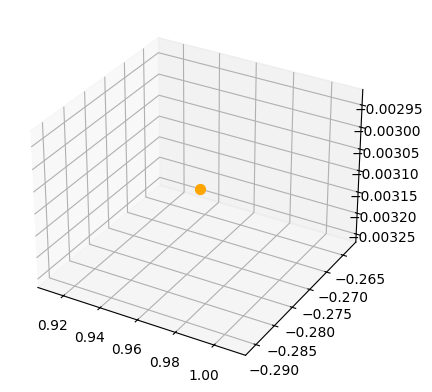

: 

In [ ]:
import os
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import numpy as np
import tkinter as tk
from datetime import datetime, timedelta
from pytz import timezone
from pysolar.solar import get_altitude, get_azimuth
from astral import LocationInfo
from astral.sun import sun
import math

# Función para cargar la imagen del panel
def load_panel_image(panel_path):
    """Carga y valida la imagen del panel."""
    if os.path.exists(panel_path):
        try:
            panel_img = mpimg.imread(panel_path)
            return panel_img
        except Exception as e:
            print(f"Error al cargar la imagen: {e}")
            exit()
    else:
        print("El archivo Panel.png no fue encontrado.")
        exit()

# Carga la imagen al inicio del programa
PANEL_IMAGE_PATH = r"C:\Users\Adrian Correa\Desktop\Proyecto-Final-Panel-Solar\Panel.png"
panel_img = load_panel_image(PANEL_IMAGE_PATH)

def getSolarPosition(latitude: float, longitude: float, date: datetime):
    """Calcula el azimut y la elevación para una posición geográfica y fecha."""
    az = get_azimuth(latitude, longitude, date)
    el = get_altitude(latitude, longitude, date)
    return az, el

def get_sunrise_sunset(latitude, longitude, date):
    """Obtiene la hora real de salida y puesta del sol para la ubicación y fecha ingresadas."""
    location = LocationInfo("Guayaquil", "Ecuador", "America/Guayaquil", latitude, longitude)
    s = sun(location.observer, date=date, tzinfo=timezone("America/Guayaquil"))
    return s['sunrise'].astimezone(timezone("America/Guayaquil")), s['sunset'].astimezone(timezone("America/Guayaquil"))

def calculate_pitch_roll(azimuth, elevation):
    """Calcula los ángulos de pitch y roll para mantener el panel perpendicular al sol."""
    theta = math.radians(elevation)
    alpha = math.radians(azimuth)

    pitch = math.degrees(math.asin(-math.cos(theta) * math.cos(alpha)))
    roll = math.degrees(math.atan2(math.cos(theta) * math.sin(alpha), math.sin(theta)))

    return pitch, roll

def interactive_plot():
    """Crea una interfaz para ingresar la fecha, duración y ubicación."""
    root = tk.Tk()
    root.title("Configuración de la Simulación Solar")

    tk.Label(root, text="Latitud:").grid(row=0, column=0)
    lat_entry = tk.Entry(root)
    lat_entry.grid(row=0, column=1)
    lat_entry.insert(0, "-0.2105367")

    tk.Label(root, text="Longitud:").grid(row=1, column=0)
    lon_entry = tk.Entry(root)
    lon_entry.grid(row=1, column=1)
    lon_entry.insert(0, "-78.491614")

    tk.Label(root, text="Fecha (YYYY-MM-DD):").grid(row=2, column=0)
    date_entry = tk.Entry(root)
    date_entry.grid(row=2, column=1)
    date_entry.insert(0, datetime.now().strftime("%Y-%m-%d"))

    sunrise_label = tk.Label(root, text="")
    sunrise_label.grid(row=4, column=0, columnspan=2)

    def update_sun_times():
        latitude = float(lat_entry.get())
        longitude = float(lon_entry.get())
        date = datetime.strptime(date_entry.get(), "%Y-%m-%d").date()
        sunrise, sunset = get_sunrise_sunset(latitude, longitude, date)
        sunrise_label.config(text=f"Salida del Sol: {sunrise.strftime('%H:%M')}  |  Puesta del Sol: {sunset.strftime('%H:%M')}")

    update_sun_times_button = tk.Button(root, text="Obtener Horas del Sol", command=update_sun_times)
    update_sun_times_button.grid(row=3, column=0, columnspan=2)

    def start_simulation():
        latitude = float(lat_entry.get())
        longitude = float(lon_entry.get())
        date = datetime.strptime(date_entry.get(), "%Y-%m-%d").date()
        sunrise, sunset = get_sunrise_sunset(latitude, longitude, date)
        root.destroy()
        plotSunAndPanelTrajectoryInWindow(sunrise, sunset, latitude, longitude)

    start_button = tk.Button(root, text="Iniciar Simulación", command=start_simulation)
    start_button.grid(row=5, column=0, columnspan=2)
    root.mainloop()

def plotSunAndPanelTrajectoryInWindow(start_time, end_time, latitude, longitude):
    """Dibuja la trayectoria del sol desde la salida hasta la puesta del sol."""
    times = []
    current_time = start_time
    while current_time <= end_time:
        times.append(current_time)
        current_time += timedelta(hours=1)

    azimuths, elevations = zip(*[getSolarPosition(latitude, longitude, time) for time in times])
    sun_x, sun_y, sun_z = spherical_to_cartesian(azimuths, elevations)

    root = tk.Tk()
    root.title("Trayectoria del Sol y Panel Solar")
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    def update_plot(i=0):
        if i < len(sun_x):
            ax.clear()
            ax.plot(sun_x[:i+1], sun_y[:i+1], sun_z[:i+1], label='Trayectoria del Sol', color='yellow', linewidth=2)
            ax.scatter(sun_x[i], sun_y[i], sun_z[i], color='orange', label=f'Sol ({times[i].strftime("%H:%M")})', s=50)

            # Mostrar la imagen del panel solar en la posición calculada
            pitch, roll = calculate_pitch_roll(azimuths[i], elevations[i])
            panel_image = OffsetImage(panel_img, zoom=0.1)
            panel_ab = AnnotationBbox(panel_image, (sun_x[i], sun_y[i]), frameon=False)
            ax.add_artist(panel_ab)

            ax.text(0, 0, 0, f"Pitch: {pitch:.2f}°\nRoll: {roll:.2f}°", fontsize=10, color='black')
            ax.set_xlabel('Eje Este-Oeste')
            ax.set_ylabel('Eje Norte-Sur')
            ax.set_zlabel('Altura (Eje Z)')
            ax.set_title(f'Trayectoria del Sol y Panel Solar\nFecha: {start_time.strftime("%Y-%m-%d")}, Desde {start_time.strftime("%H:%M")} hasta {end_time.strftime("%H:%M")}')
            ax.legend()
            canvas.draw()
            root.after(500, update_plot, i + 1)
        else:
            root.after(1000, update_plot, 0)

    update_plot()
    root.mainloop()

def spherical_to_cartesian(azimuths, elevations):
    """Convierte azimut y elevación a coordenadas 3D esféricas."""
    azimuths_rad = np.radians(azimuths)
    elevations_rad = np.radians(elevations)
    sun_x = np.cos(elevations_rad) * np.sin(azimuths_rad)
    sun_y = np.cos(elevations_rad) * np.cos(azimuths_rad)
    sun_z = np.sin(elevations_rad)
    return sun_x, sun_y, sun_z

if __name__ == "__main__":
    interactive_plot()


Error al cargar la imagen: not a PNG file


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\Adrian Correa\AppData\Local\Programs\Python\Python313\Lib\tkinter\__init__.py", line 2068, in __call__
    return self.func(*args)
           ~~~~~~~~~^^^^^^^
  File "C:\Users\Adrian Correa\AppData\Local\Temp\ipykernel_3444\1044818062.py", line 94, in start_simulation
    plotSunAndPanelTrajectoryInWindow(sunrise, sunset, latitude, longitude)
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Adrian Correa\AppData\Local\Temp\ipykernel_3444\1044818062.py", line 141, in plotSunAndPanelTrajectoryInWindow
    update_plot()
    ~~~~~~~~~~~^^
  File "C:\Users\Adrian Correa\AppData\Local\Temp\ipykernel_3444\1044818062.py", line 126, in update_plot
    panel_image = OffsetImage(panel_img, zoom=0.1)
  File "c:\Users\Adrian Correa\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\offsetbox.py", line 1141, in __init__
    self.set_data(arr)
    ~~~~~~~~~~~

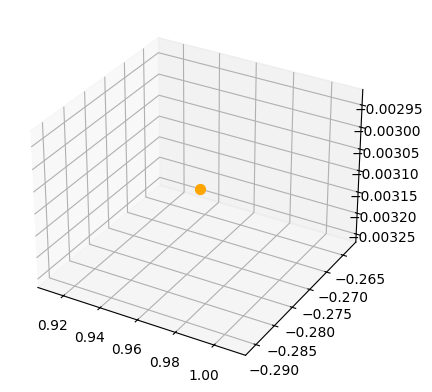

: 

In [ ]:
import os
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import numpy as np
import tkinter as tk
from datetime import datetime, timedelta
from pytz import timezone
from pysolar.solar import get_altitude, get_azimuth
from astral import LocationInfo
from astral.sun import sun
import math

# Función para cargar la imagen del panel
def load_panel_image(panel_path):
    """Carga y valida la imagen del panel."""
    if os.path.exists(panel_path):
        try:
            panel_img = mpimg.imread(panel_path)
            return panel_img
        except Exception as e:
            print(f"Error al cargar la imagen: {e}")
            exit()
    else:
        print("El archivo Panel.png no fue encontrado.")
        exit()

# Carga la imagen al inicio del programa
PANEL_IMAGE_PATH = r"C:\Users\Adrian Correa\Desktop\Proyecto-Final-Panel-Solar\Panel.png"
panel_img = load_panel_image(PANEL_IMAGE_PATH)

def getSolarPosition(latitude: float, longitude: float, date: datetime):
    """Calcula el azimut y la elevación para una posición geográfica y fecha."""
    az = get_azimuth(latitude, longitude, date)
    el = get_altitude(latitude, longitude, date)
    return az, el

def get_sunrise_sunset(latitude, longitude, date):
    """Obtiene la hora real de salida y puesta del sol para la ubicación y fecha ingresadas."""
    location = LocationInfo("Guayaquil", "Ecuador", "America/Guayaquil", latitude, longitude)
    s = sun(location.observer, date=date, tzinfo=timezone("America/Guayaquil"))
    return s['sunrise'].astimezone(timezone("America/Guayaquil")), s['sunset'].astimezone(timezone("America/Guayaquil"))

def calculate_pitch_roll(azimuth, elevation):
    """Calcula los ángulos de pitch y roll para mantener el panel perpendicular al sol."""
    theta = math.radians(elevation)
    alpha = math.radians(azimuth)

    pitch = math.degrees(math.asin(-math.cos(theta) * math.cos(alpha)))
    roll = math.degrees(math.atan2(math.cos(theta) * math.sin(alpha), math.sin(theta)))

    return pitch, roll

def interactive_plot():
    """Crea una interfaz para ingresar la fecha, duración y ubicación."""
    root = tk.Tk()
    root.title("Configuración de la Simulación Solar")

    tk.Label(root, text="Latitud:").grid(row=0, column=0)
    lat_entry = tk.Entry(root)
    lat_entry.grid(row=0, column=1)
    lat_entry.insert(0, "-0.2105367")

    tk.Label(root, text="Longitud:").grid(row=1, column=0)
    lon_entry = tk.Entry(root)
    lon_entry.grid(row=1, column=1)
    lon_entry.insert(0, "-78.491614")

    tk.Label(root, text="Fecha (YYYY-MM-DD):").grid(row=2, column=0)
    date_entry = tk.Entry(root)
    date_entry.grid(row=2, column=1)
    date_entry.insert(0, datetime.now().strftime("%Y-%m-%d"))

    sunrise_label = tk.Label(root, text="")
    sunrise_label.grid(row=4, column=0, columnspan=2)

    def update_sun_times():
        latitude = float(lat_entry.get())
        longitude = float(lon_entry.get())
        date = datetime.strptime(date_entry.get(), "%Y-%m-%d").date()
        sunrise, sunset = get_sunrise_sunset(latitude, longitude, date)
        sunrise_label.config(text=f"Salida del Sol: {sunrise.strftime('%H:%M')}  |  Puesta del Sol: {sunset.strftime('%H:%M')}")

    update_sun_times_button = tk.Button(root, text="Obtener Horas del Sol", command=update_sun_times)
    update_sun_times_button.grid(row=3, column=0, columnspan=2)

    def start_simulation():
        latitude = float(lat_entry.get())
        longitude = float(lon_entry.get())
        date = datetime.strptime(date_entry.get(), "%Y-%m-%d").date()
        sunrise, sunset = get_sunrise_sunset(latitude, longitude, date)
        root.destroy()
        plotSunAndPanelTrajectoryInWindow(sunrise, sunset, latitude, longitude)

    start_button = tk.Button(root, text="Iniciar Simulación", command=start_simulation)
    start_button.grid(row=5, column=0, columnspan=2)
    root.mainloop()

def plotSunAndPanelTrajectoryInWindow(start_time, end_time, latitude, longitude):
    """Dibuja la trayectoria del sol desde la salida hasta la puesta del sol."""
    times = []
    current_time = start_time
    while current_time <= end_time:
        times.append(current_time)
        current_time += timedelta(hours=1)

    azimuths, elevations = zip(*[getSolarPosition(latitude, longitude, time) for time in times])
    sun_x, sun_y, sun_z = spherical_to_cartesian(azimuths, elevations)

    root = tk.Tk()
    root.title("Trayectoria del Sol y Panel Solar")
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    def update_plot(i=0):
        if i < len(sun_x):
            ax.clear()
            ax.plot(sun_x[:i+1], sun_y[:i+1], sun_z[:i+1], label='Trayectoria del Sol', color='yellow', linewidth=2)
            ax.scatter(sun_x[i], sun_y[i], sun_z[i], color='orange', label=f'Sol ({times[i].strftime("%H:%M")})', s=50)

            # Mostrar la imagen del panel solar en la posición calculada
            pitch, roll = calculate_pitch_roll(azimuths[i], elevations[i])
            panel_image = OffsetImage(panel_img, zoom=0.1)
            panel_ab = AnnotationBbox(panel_image, (sun_x[i], sun_y[i]), frameon=False)
            ax.add_artist(panel_ab)

            ax.text(0, 0, 0, f"Pitch: {pitch:.2f}°\nRoll: {roll:.2f}°", fontsize=10, color='black')
            ax.set_xlabel('Eje Este-Oeste')
            ax.set_ylabel('Eje Norte-Sur')
            ax.set_zlabel('Altura (Eje Z)')
            ax.set_title(f'Trayectoria del Sol y Panel Solar\nFecha: {start_time.strftime("%Y-%m-%d")}, Desde {start_time.strftime("%H:%M")} hasta {end_time.strftime("%H:%M")}')
            ax.legend()
            canvas.draw()
            root.after(500, update_plot, i + 1)
        else:
            root.after(1000, update_plot, 0)

    update_plot()
    root.mainloop()

def spherical_to_cartesian(azimuths, elevations):
    """Convierte azimut y elevación a coordenadas 3D esféricas."""
    azimuths_rad = np.radians(azimuths)
    elevations_rad = np.radians(elevations)
    sun_x = np.cos(elevations_rad) * np.sin(azimuths_rad)
    sun_y = np.cos(elevations_rad) * np.cos(azimuths_rad)
    sun_z = np.sin(elevations_rad)
    return sun_x, sun_y, sun_z

if __name__ == "__main__":
    interactive_plot()


In [2]:
import os

panel_path = r"C:\Users\Adrian Correa\Desktop\Proyecto-Final-Panel-Solar\Panel.png"
if os.path.exists(panel_path):
    print("El archivo Panel.png fue encontrado correctamente.")
else:
    print("El archivo Panel.png no fue encontrado.")



El archivo Panel.png fue encontrado correctamente.
